# Based on [https://bering-ivis.readthedocs.io/en/latest/metric_learning.html ](http://)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
!pip install ivis

!git clone https://github.com/beringresearch/ivis-explain
!pip install --editable  ./ivis-explain

Cloning into 'ivis-explain'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 51 (delta 10), reused 47 (delta 6), pack-reused 0
Unpacking objects: 100% (51/51), done.
Obtaining file:///kaggle/working/ivis-explain
  Created wheel for lapjv: filename=lapjv-1.3.1-cp37-cp37m-linux_x86_64.whl size=88752 sha256=9b8c7a90145110e985de50c4ea366ffd0072c8ad6419674cd7321c32855242e0
  Stored in directory: /root/.cache/pip/wheels/37/68/63/059ec4da455f2b9e81e989088f69c6f89030b061180457ec06
Successfully built lapjv
  Running setup.py develop for ivis-explanations


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('./ivis-explain'))
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression

from ivis import Ivis
from ivis_explanations import LinearExplainer



In [4]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
Y = data['Class']
X = data.drop(['Class','Time'], axis=1)

The Credit Card Fraud dataset is highly skewed, consisting of 492 frauds in a total of 284,807 observations (0.17% fraud cases). The features consist of numerical values from the 28 ‘Principal Component Analysis (PCA)’ transformed features, as well as Time and Amount of a transaction.

In this analysis we will train ivis algorithm using a 5% stratified subsample of the dataset. Our previous experiments have shown that ivis can yield >90% accurate embeddings using just 1% of the total data.

In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, stratify=Y, test_size=0.8, random_state=1234)

Next, because ivis will learn a distance over observations, scaling must be applied to features. 

Additionally, transforming the data to a range [0, 1] allows the neural network to extract more meaningful features.

In [6]:
# standard_scaler = StandardScaler().fit(train_X[['Time', 'Amount']])
# train_X.loc[:, ['Time', 'Amount']] = standard_scaler.transform(train_X[['Time', 'Amount']])
# test_X.loc[:, ['Time', 'Amount']] = standard_scaler.transform(test_X[['Time', 'Amount']])

standard_scaler = StandardScaler().fit(train_X[['Amount']])
train_X.loc[:, ['Amount']] = standard_scaler.transform(train_X[['Amount']])
test_X.loc[:, ['Amount']] = standard_scaler.transform(test_X[['Amount']])
minmax_scaler = MinMaxScaler().fit(train_X)
train_X = minmax_scaler.transform(train_X)
test_X = minmax_scaler.transform(test_X)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib

# Dimensionality Reduction

Now, we can run ivis using default hyperparameters for supervised embedding problems:

In [7]:
ivis = Ivis(embedding_dims=2, model='maaten',
            k=15, n_epochs_without_progress=5,
            supervision_weight=0.95,
            verbose=0)
ivis.fit(train_X, train_Y.values)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Ivis(annoy_index_path='annoy.index', build_index_on_disk=True, k=15, model=None,
     n_epochs_without_progress=5, supervision_weight=0.95, verbose=0)

In [8]:
ivis.save_model('ivis-supervised-fraud', overwrite=True)

Embed the training set and extrapolate learnt embeddings to the testing set

In [9]:
train_embeddings = ivis.transform(train_X)
test_embeddings = ivis.transform(test_X)

# **Visualisations**

Text(0.5, 1.0, 'Testing Set')

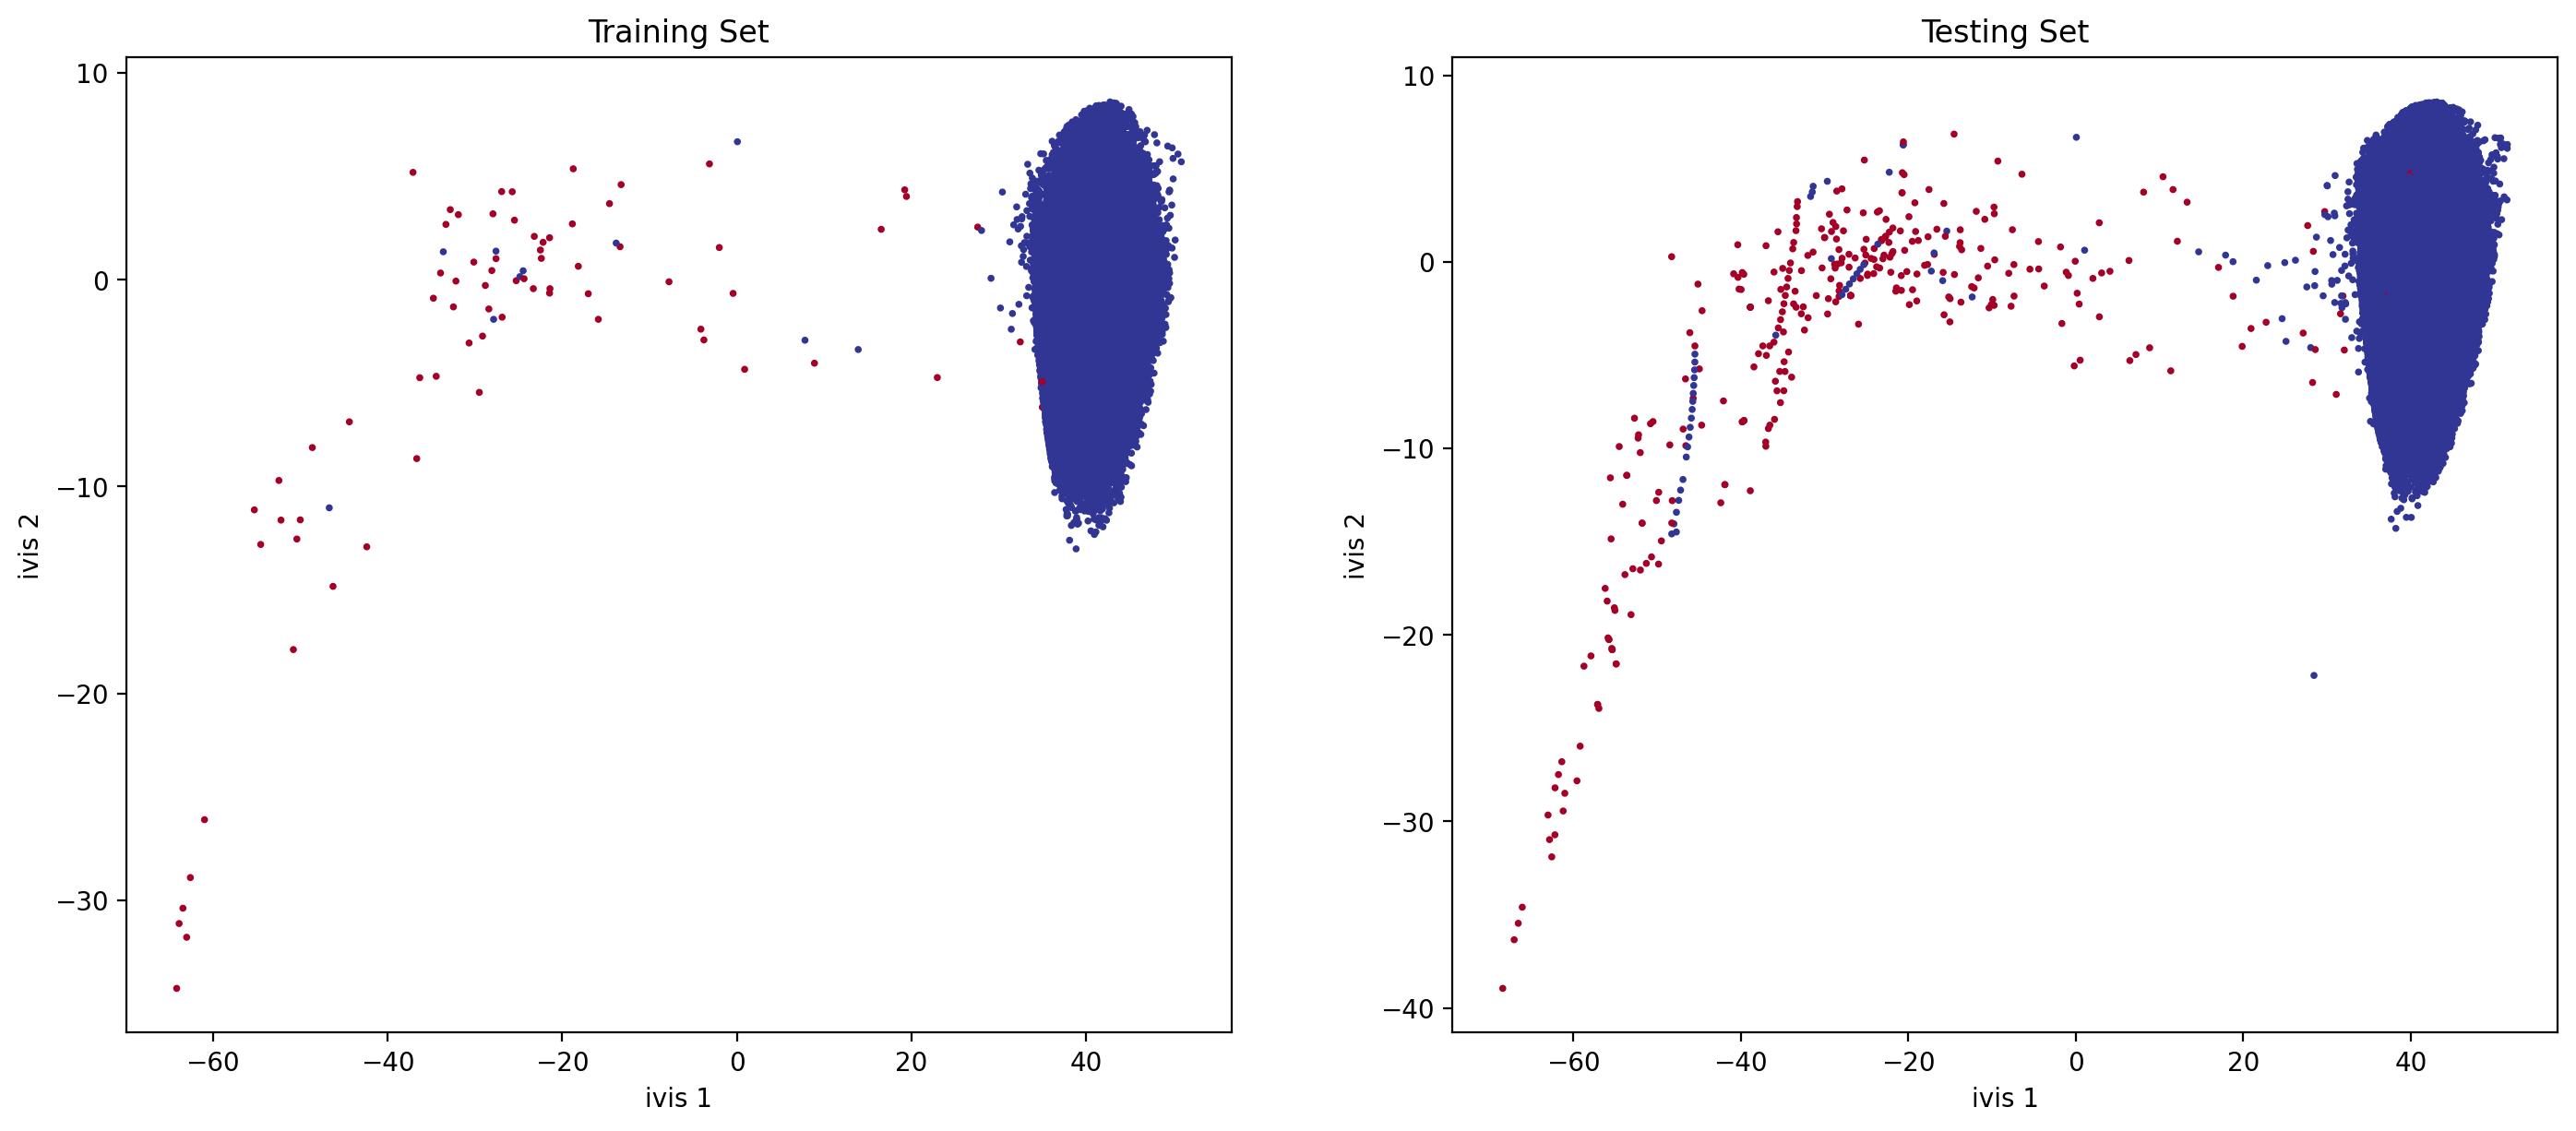

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7), dpi=200)
ax[0].scatter(x=train_embeddings[:, 0], y=train_embeddings[:, 1], c=train_Y, s=3, cmap='RdYlBu_r')
ax[0].set_xlabel('ivis 1')
ax[0].set_ylabel('ivis 2')
ax[0].set_title('Training Set')

ax[1].scatter(x=test_embeddings[:, 0], y=test_embeddings[:, 1], c=test_Y, s=3, cmap='RdYlBu_r')
ax[1].set_xlabel('ivis 1')
ax[1].set_ylabel('ivis 2')
ax[1].set_title('Testing Set')

# Linear Classifier
train a simple linear classifier to assess how well ivis learned the class representations.

In [11]:
clf = LogisticRegression(solver="lbfgs").fit(train_embeddings, train_Y)

In [12]:
labels = clf.predict(test_embeddings)
proba = clf.predict_proba(test_embeddings)

In [13]:
print(classification_report(test_Y, labels))

print('Confusion Matrix')
print(confusion_matrix(test_Y, labels))
print('Average Precision: '+str(average_precision_score(test_Y, proba[:, 1])))
print('ROC AUC: '+str(roc_auc_score(test_Y, labels)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227452
           1       0.87      0.69      0.77       394

    accuracy                           1.00    227846
   macro avg       0.93      0.85      0.88    227846
weighted avg       1.00      1.00      1.00    227846

Confusion Matrix
[[227410     42]
 [   122    272]]
Average Precision: 0.7055987505984185
ROC AUC: 0.8450853378022927


# **ROC Curve: Plot of False Positive Rate (x) vs. True Positive Rate (y)**

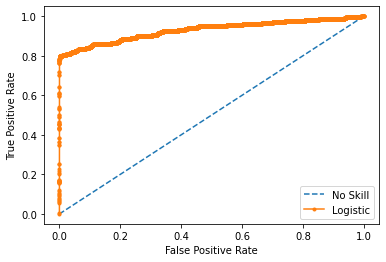

In [14]:
# retrieve just the probabilities for the positive class
pos_probs = proba[:, 1]

# calculate roc curve for model
fpr, tpr, thresholds = roc_curve(test_Y, pos_probs)

# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# The Precision-Recall Curve for the Logistic Regression

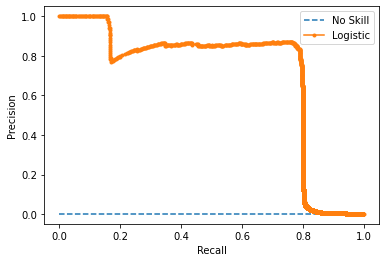

In [15]:
# calculate the no skill line as the proportion of the positive class
no_skill = len(Y[Y==1]) / len(Y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(test_Y, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

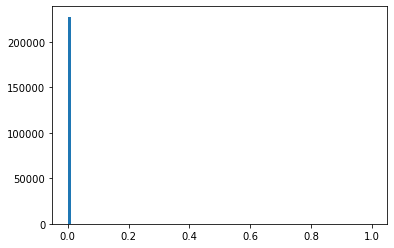

In [16]:
# create a histogram of the predicted probabilities
plt.hist(pos_probs, bins=100)
plt.show()

In [17]:
explainer = LinearExplainer(ivis)
explainer.feature_importances_(train_X)

array([5.66952626e-03, 5.55233472e-03, 1.39421567e-02, 1.11622506e-01,
       4.32414979e-03, 4.06924403e-03, 1.52068623e-02, 1.24039756e-04,
       1.91353836e-03, 2.94205872e-02, 1.28144801e-01, 3.69258216e-02,
       8.56037053e-01, 4.12046978e-02, 1.41881640e-02, 1.30571332e-02,
       5.33265111e-02, 8.68878323e-03, 7.32782573e-02, 1.27807727e-04,
       5.43199903e-05, 8.01631607e-04, 3.94398464e-05, 1.88897104e-01,
       1.68222534e-03, 2.65338926e-01, 3.35897187e-05, 5.21837403e-05,
       8.06939944e-05])